# Analysing Wildfire activities in Australia 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

In [6]:
import pandas as pd
import aiohttp
import io

async def fetch_data(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            return await response.text()

URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/Historical_Wildfires.csv"

# Asynchronous function to fetch data
data_text = await fetch_data(URL)

# Use StringIO to convert the response content into a file-like object
text = io.StringIO(data_text)

# Read the CSV into a DataFrame
df = pd.read_csv(text)

# Print a message
print('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [9]:
df.shape

(26406, 10)

In [11]:
import datetime as dt
df['year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month

In [12]:
df.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,year,Month
0,NSW,1/4/2005,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R,2005,1
1,NSW,1/5/2005,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R,2005,1
2,NSW,1/6/2005,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R,2005,1
3,NSW,1/7/2005,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R,2005,1
4,NSW,1/8/2005,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R,2005,1


In [20]:
df_avgfire = df.groupby(by='year')['Estimated_fire_area'].mean()
df_avgfire = pd.DataFrame(df_avgfire)
df_avgfire

,Estimated_fire_area
year,
2005,92.770501
2006,176.289434
2007,153.112464
2008,99.758968
2009,141.624955
2010,62.429968
2011,266.936175
2012,265.526196
2013,95.896092


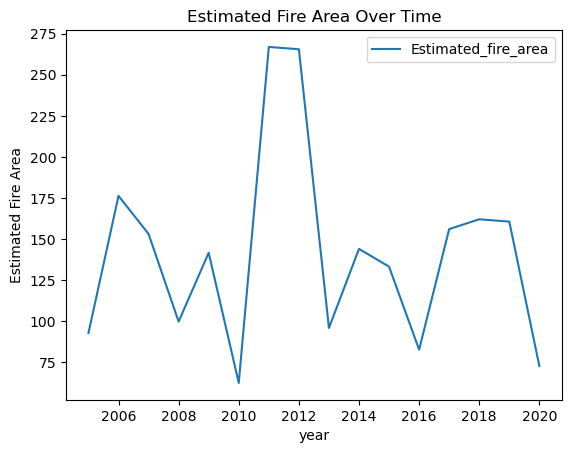

In [30]:
df_avgfire.plot(kind='line')
plt.ylabel('Estimated Fire Area')
plt.title('Estimated Fire Area Over Time')
plt.show()

<Axes: xlabel='year,Month'>

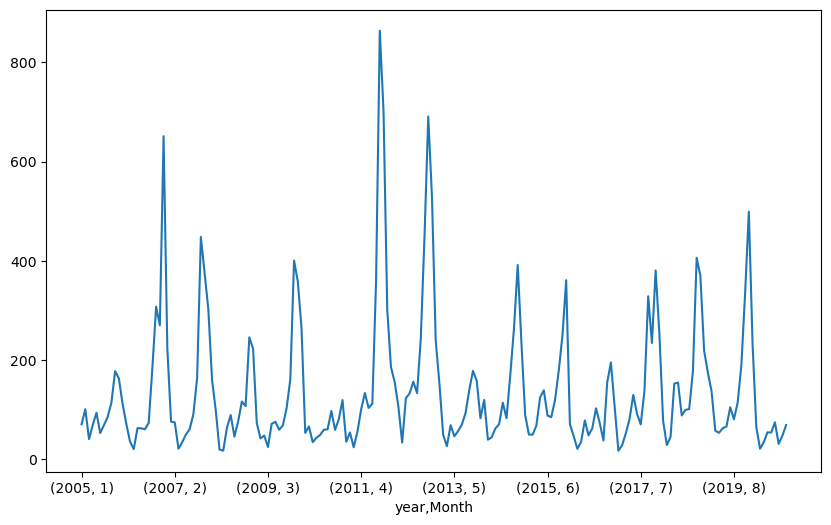

In [95]:
df_fire2 = df.groupby(by=['year', 'Month'])['Estimated_fire_area'].mean()
plt.figure(figsize=(10,6))
df_fire2.plot(x=df_fire2.index, y=df_fire2.values)

In [99]:
df_mereg = df.groupby(by='Region')['Mean_estimated_fire_brightness'].mean()
df_mereg = pd.DataFrame(df_mereg)
df_mereg

,Mean_estimated_fire_brightness
Region,
NSW,315.526218
NT,322.898453
QL,318.364434
SA,321.497609
TA,313.368483
VI,315.029792
WA,324.142246


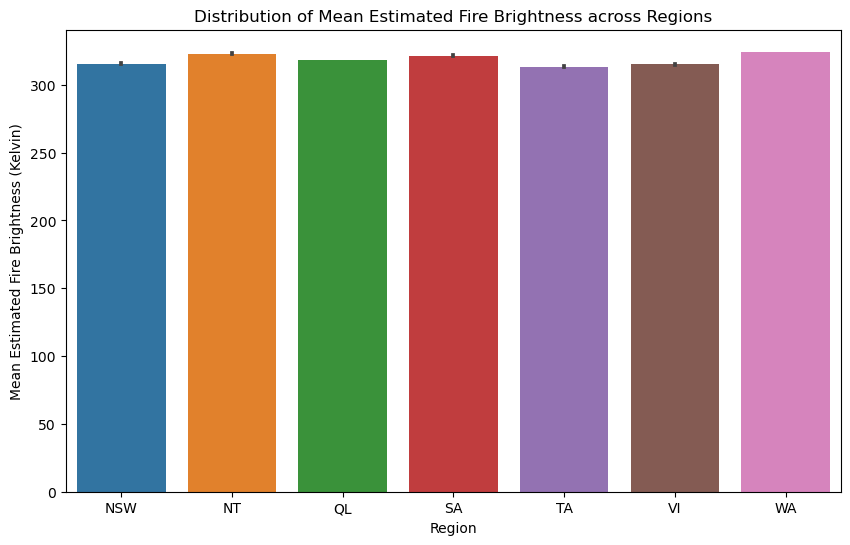

In [105]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Region', y='Mean_estimated_fire_brightness')
plt.xlabel('Region')
plt.ylabel('Mean Estimated Fire Brightness (Kelvin)')
plt.title('Distribution of Mean Estimated Fire Brightness across Regions')
plt.show()

In [111]:
df_pix = df.groupby('Region')['Count'].sum()
df_pix

Region
NSW    117412
NT     649430
QL     420882
SA      35160
TA      11473
VI      52473
WA     615968
Name: Count, dtype: int64

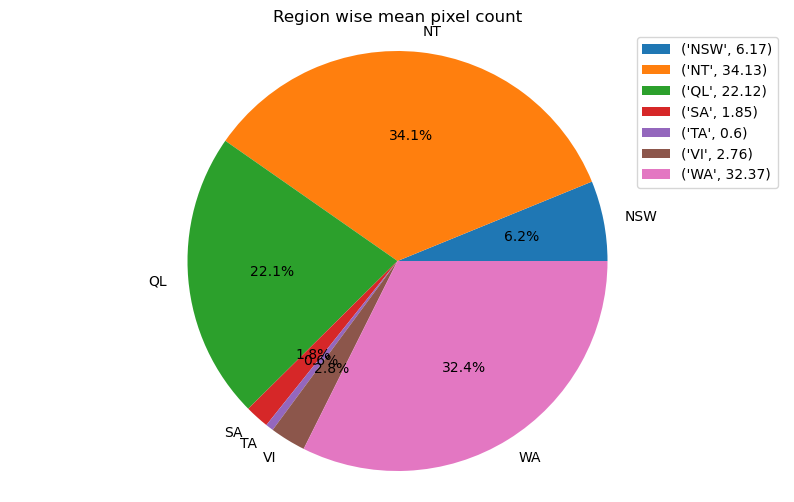

In [122]:
plt.figure(figsize=(10,6))
plt.pie(df_pix, labels=df_pix.index, autopct='%1.1f%%')
plt.legend([(i,round(k/df_pix.sum()*100,2)) for i, k in zip(df_pix.index, df_pix)])
plt.title('Region wise mean pixel count')
plt.axis('equal')
plt.show()

<Axes: ylabel='Frequency'>

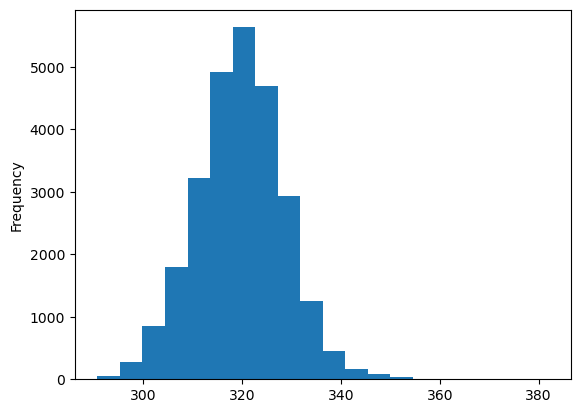

In [125]:
df['Mean_estimated_fire_brightness'].plot(kind='hist', bins=20)

<Axes: xlabel='Mean_estimated_fire_brightness', ylabel='Count'>

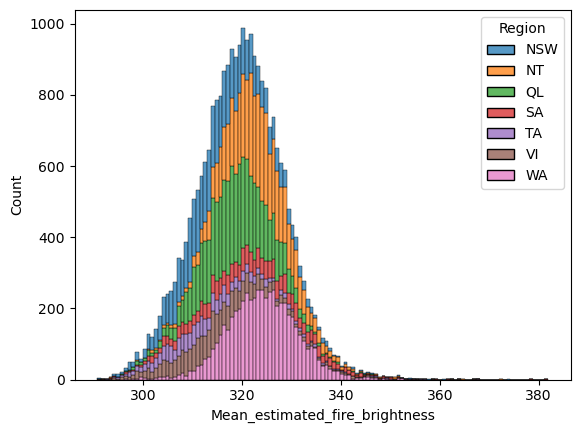

In [129]:
sns.histplot(df, x='Mean_estimated_fire_brightness', hue='Region', multiple='stack')

<Axes: xlabel='Mean_confidence', ylabel='Mean_estimated_fire_radiative_power'>

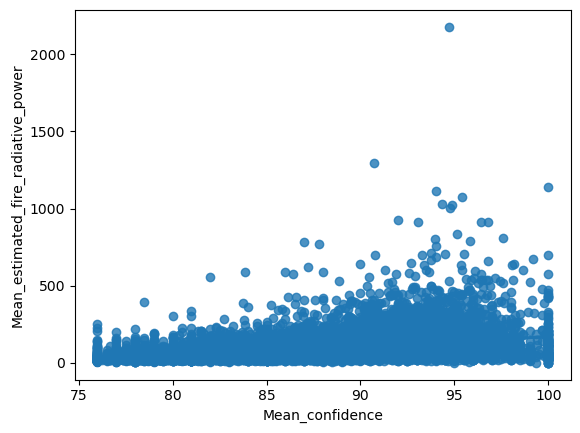

In [130]:
sns.regplot(x='Mean_confidence', y='Mean_estimated_fire_radiative_power', data=df)

<Axes: xlabel='Mean_confidence', ylabel='Mean_estimated_fire_radiative_power'>

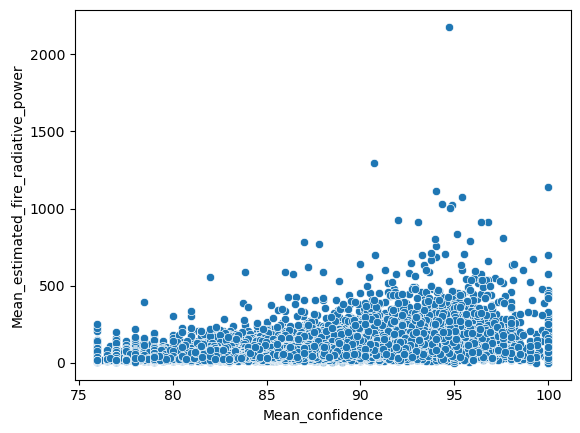

In [131]:
sns.scatterplot(data=df, x='Mean_confidence', y='Mean_estimated_fire_radiative_power')

In [132]:
region_data = {'region':['NSW','QL','SA','TA','VI','WA','NT'], 'Lat':[-31.8759835,-22.1646782,-30.5343665,-42.035067,-36.5986096,-25.2303005,-19.491411], 
               'Lon':[147.2869493,144.5844903,135.6301212,146.6366887,144.6780052,121.0187246,132.550964]}
reg=pd.DataFrame(region_data)
reg

,region,Lat,Lon
0,NSW,-31.875984,147.286949
1,QL,-22.164678,144.584490
2,SA,-30.534367,135.630121
3,TA,-42.035067,146.636689
4,VI,-36.598610,144.678005
5,WA,-25.230300,121.018725
6,NT,-19.491411,132.550964


In [133]:
# instantiate a feature group 
aus_reg = folium.map.FeatureGroup()

# Create a Folium map centered on Australia
Aus_map = folium.Map(location=[-25, 135], zoom_start=4)

# loop through the region and add to feature group
for lat, lng, lab in zip(reg.Lat, reg.Lon, reg.region):
    aus_reg.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            popup=lab,
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
Aus_map.add_child(aus_reg)